In [1]:
%load_ext autoreload
%autoreload 2
import torch 
import glob
from torchvision.io import read_image
from matplotlib import pyplot as plt
from math import pi as PI


In [2]:
images = glob.glob("renders/*.png")
images = sorted(images,key=lambda fn:int(fn.split(".")[0].split("_")[1]))

all_images = torch.stack([read_image(p) for p in images]).cuda().float()
all_images /= 255.0


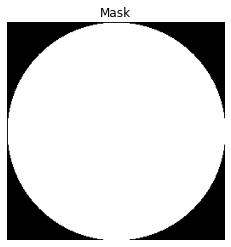

In [3]:
img_size = all_images.shape[2:4]
x = torch.arange(-1,1,2/img_size[0])
y = torch.arange(-1,1,2/img_size[1])
x_grid,y_grid = torch.meshgrid(x,y,indexing="ij")
mask = (x_grid.square()+y_grid.square())<1
plt.imshow(mask,cmap="gray")
plt.axis("off")
plt.title("Mask")
mask = mask.float().cuda()

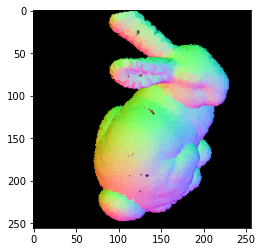

In [4]:

alpha_mask = all_images[:,3:4] * mask
alpha_weighted = all_images[:,:3] * alpha_mask
avg_colors = alpha_weighted.sum(dim=(2,3)) / alpha_mask.sum(dim=(2,3))

plt.imshow((all_images[4,:3]*mask).permute(1,2,0).cpu())

12 14


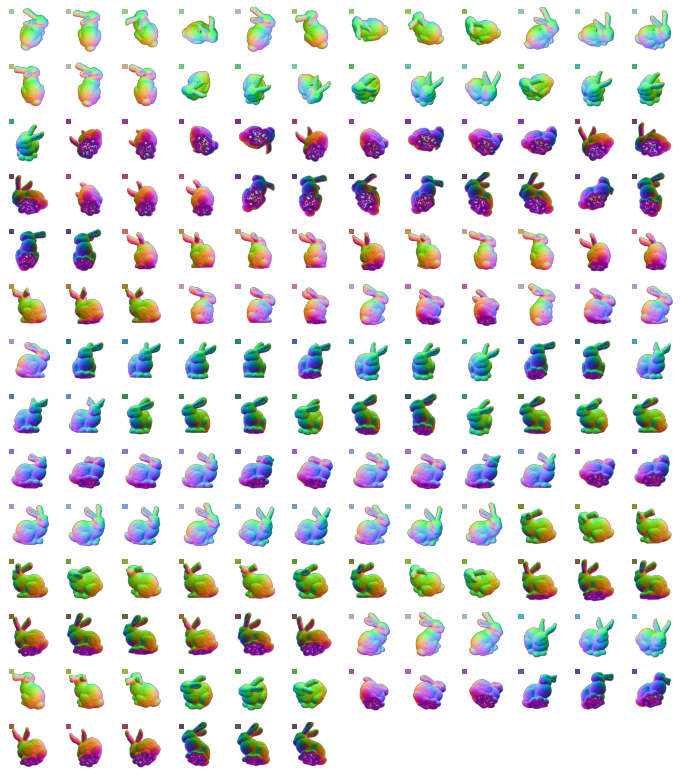

In [5]:
import math
from matplotlib.patches import Rectangle

num_images = avg_colors.shape[0]

num_cols = int(math.sqrt(num_images))
num_rows = math.ceil(num_images/num_cols)

print(num_cols,num_rows)

fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_cols,num_rows))

for i in range(num_rows*num_cols):
    row = i//num_cols
    col = i%num_cols
    ax = axes[row][col]
    ax.set_axis_off()
    if i >= num_images:
        continue
    
    ax.imshow(all_images[i].cpu().permute((1,2,0)))
    ax.add_patch(Rectangle((10,10),30,30,facecolor=avg_colors[i].cpu().numpy()))

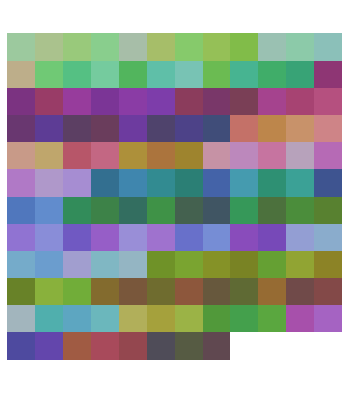

In [6]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(num_cols/2,num_rows/2))

ax.set_ylim((0,num_rows*10))
ax.set_xlim((0,num_cols*10))
ax.set_axis_off()
for i in range(num_images):
    row = num_cols- i//num_rows
    col = i%num_rows
    ax.add_patch(Rectangle((col*10,row*10),10,10,facecolor=avg_colors[i].cpu().numpy()))

In [7]:
from plyfile import PlyData, PlyElement
import numpy as np

plydata = PlyData.read('../sphere.ply')
positions = np.stack([plydata["vertex"].data["x"],plydata["vertex"].data["y"],plydata["vertex"].data["z"]]).T
cameras = torch.from_numpy(positions)

In [8]:
def to_spherical(coords):
    assert (coords.norm(p=2,dim=1)-1 < 1e-8).all(), "must be of length 1"

    theta = coords[:,2].acos()
    phi = torch.atan2(coords[:,1],coords[:,0]) + PI
    return torch.stack([theta,phi]).T


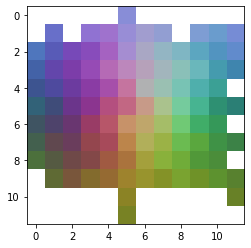

In [9]:

cameras_spherical = to_spherical(cameras)

res = 12

pos_norm = cameras_spherical.clone()
pos_norm[:,0]/=PI
pos_norm[:,1]/=2*PI

# scale to the center of the pixels and convert to index
pos_norm = (pos_norm * (res-1) + 1/ res).long()
# plt.imshow(render.cpu())
#render[pos_norm] = 0

#plt.imshow(render)
render = torch.ones((res,res,3))

for i,p in enumerate(pos_norm):
    render[p[0]][p[1]] = avg_colors[i].cpu()
plt.imshow(render)

In [10]:
render[6,6]

tensor([0.7503, 0.6513, 0.4230])

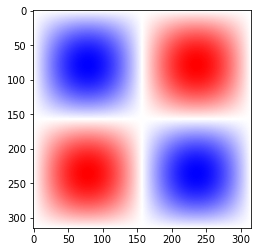

In [11]:

from sh import get_spherical_harmonics,get_spherical_harmonics_element,get_spherical_harmonics_2
resolution = 100
x = torch.arange(0,PI,1/resolution)
y = torch.arange(0,2*PI,2/resolution)
x_grid,y_grid = torch.meshgrid(x,y, indexing='ij')

l = 2
m = -1

values = get_spherical_harmonics_element(l,m,x_grid,y_grid)


plt.imshow(values,cmap="bwr")

# SH Testing 

Picking random coefficients, render them, and try to estimate them again'

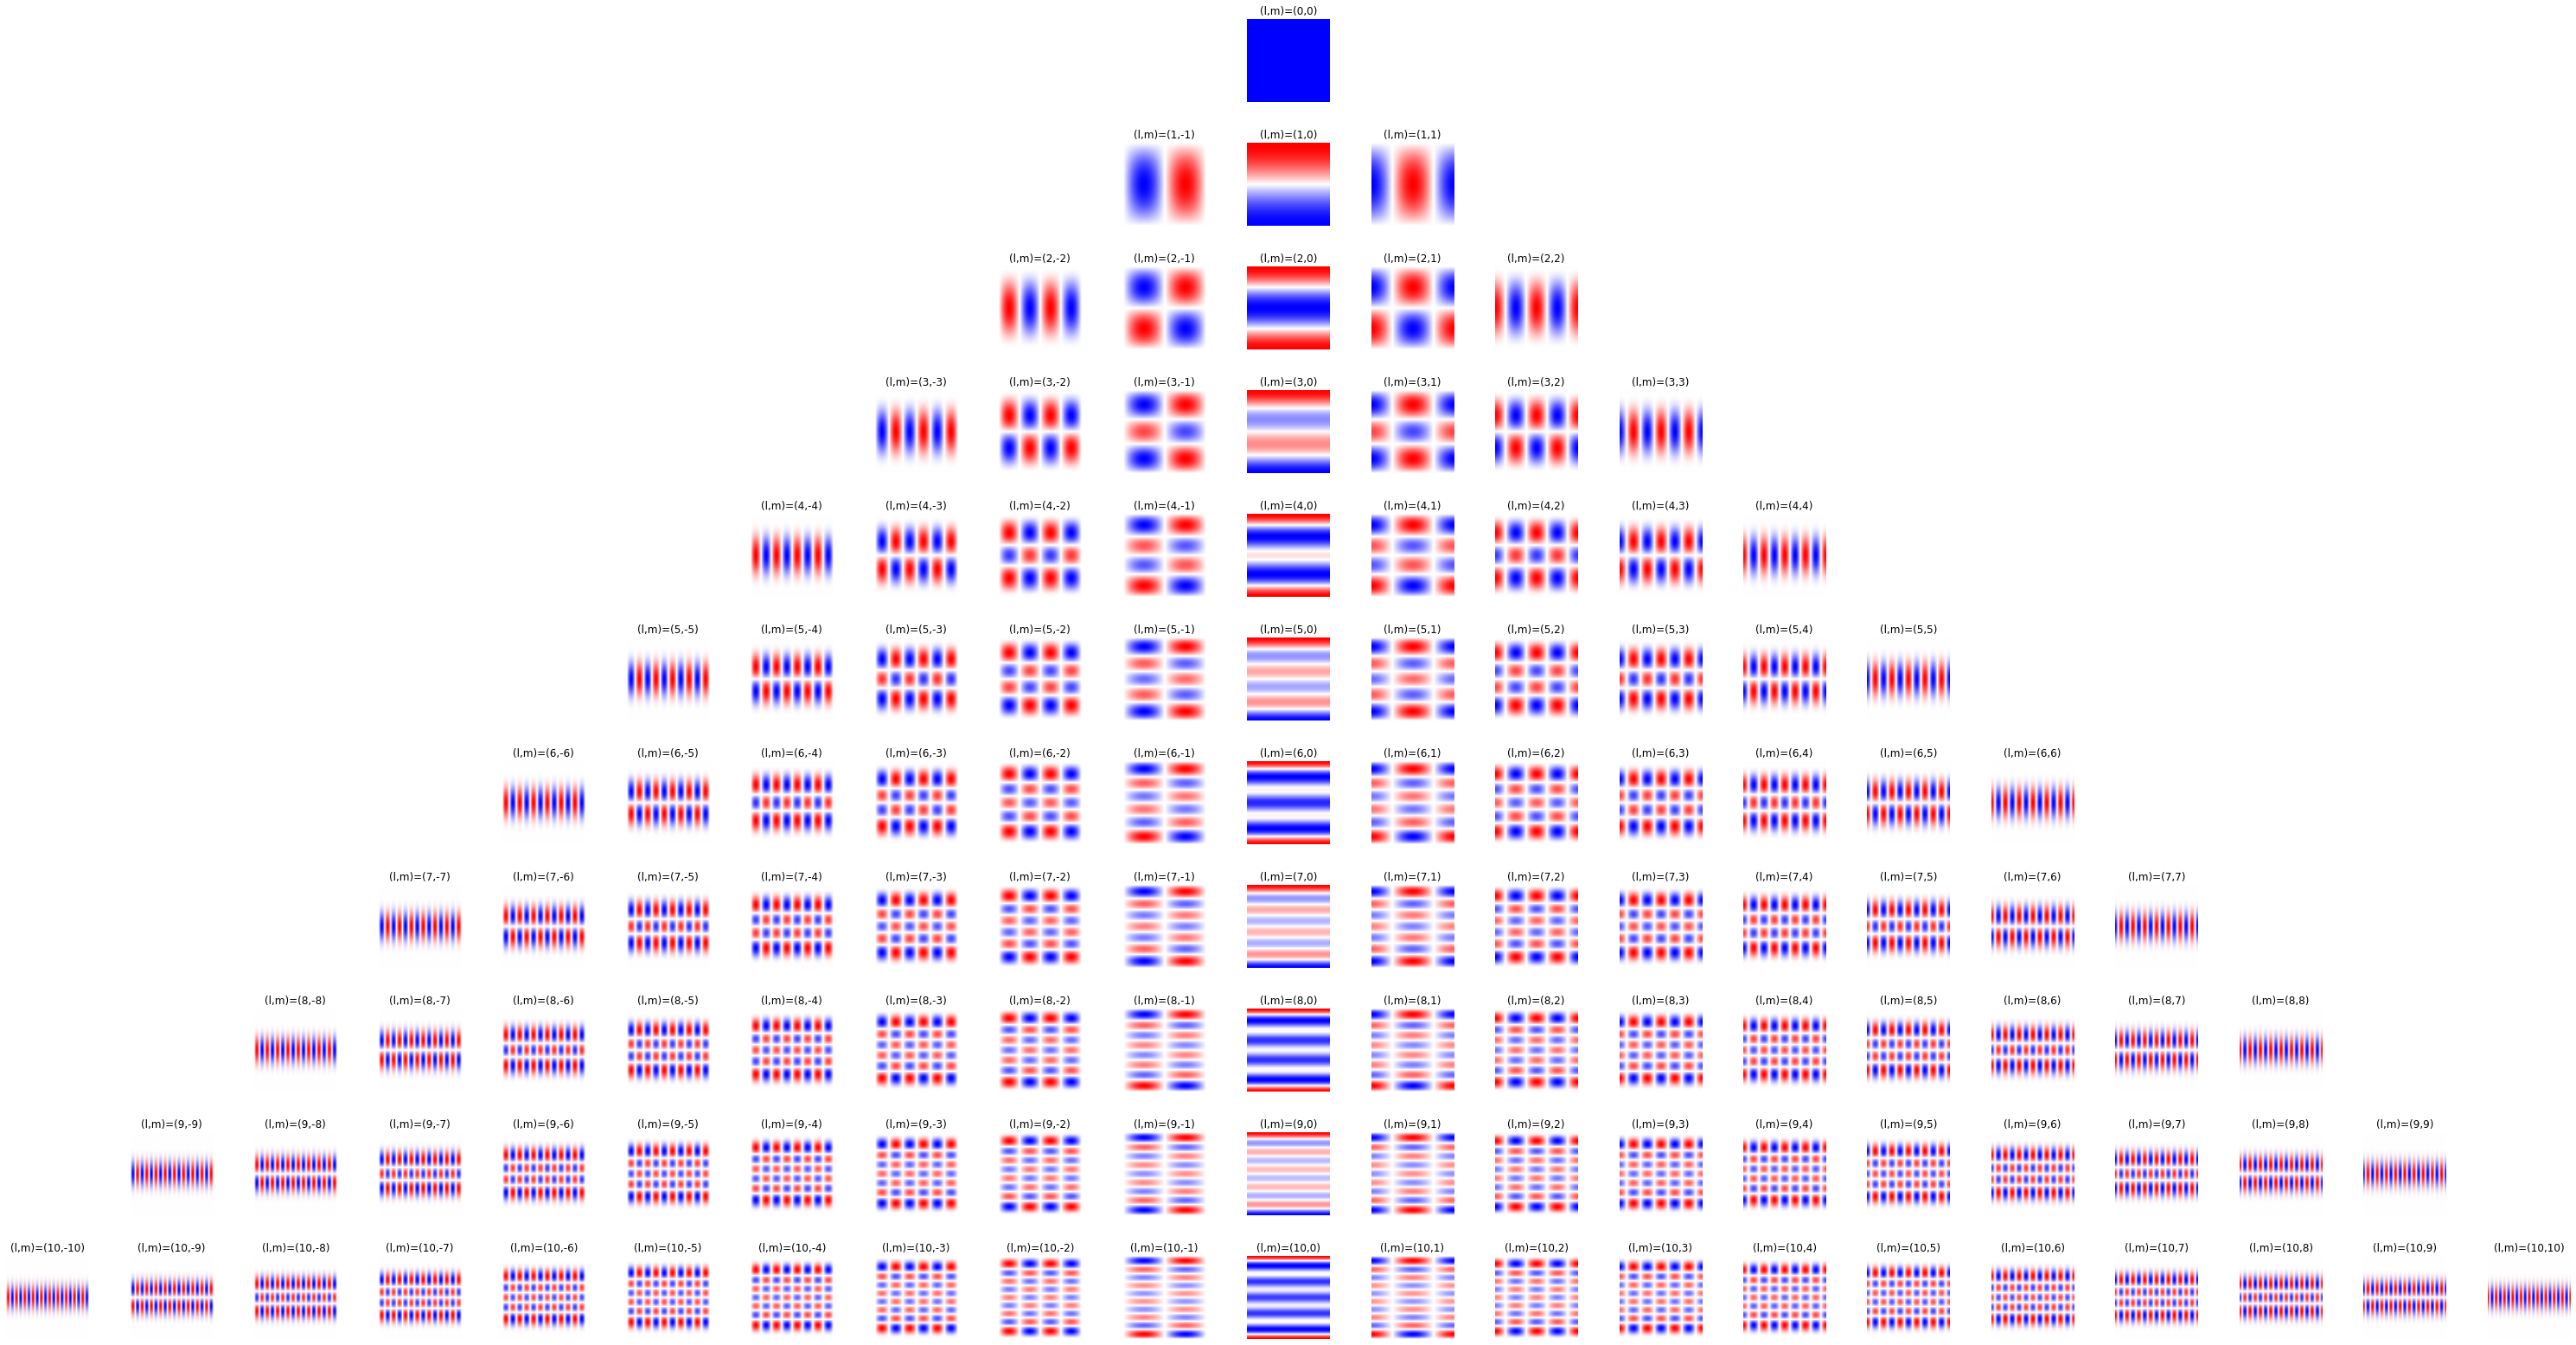

In [12]:
l_max = 10
fig,axes = plt.subplots(l_max+1,l_max*2+1,figsize=(2*(l_max*2+1),2*(l_max+1)))
fig.tight_layout()

x = torch.arange(0,PI,1/resolution)
y = torch.arange(0,2*PI,2/resolution)
x_grid,y_grid = torch.meshgrid(x,y, indexing='ij')

for l in range(l_max+1):
    for m in range(l_max*2+1):
        axes[l][m].set_axis_off()

for l in range(l_max+1):
    for m in range(-l,l+1):
        img_data = get_spherical_harmonics_element(l,m,x_grid,y_grid)
        ax = axes[l][l_max+m]
        ax.imshow(img_data,cmap="bwr")
        ax.set_title(f"(l,m)=({l},{m})")
        ax.set_yticks([])
        ax.set_xticks([])
        

In [122]:
def calc_point_weights(coords_sperical,n=100):
    x = torch.arange(0,PI,PI/n)
    y = torch.arange(0,2*PI,2*PI/n)
    spherical_grid = torch.dstack(torch.meshgrid(x,y, indexing='ij')).flatten(0,1)

    distances = torch.cdist(coords_sperical,spherical_grid,p=2)

    nearest = distances.argmin(dim=0).reshape((n,n))

    _,counts = nearest.unique(sorted=True,return_counts=True)

    return counts/counts.sum()

camera_weights = 2*PI**2* calc_point_weights(cameras_spherical)

In [174]:
n = math.ceil(math.sqrt(162))

theta = torch.arange(0,PI,PI/n)
phi = torch.arange(0,2*PI,2*PI/n)


theta_grid,phi_grid = torch.meshgrid(theta,phi, indexing='ij')
theta_grid = theta_grid.flatten()
phi_grid = phi_grid.flatten()

target = torch.ones((n*n,1))

l_max = 0

delta = 2* PI**2 / target.shape[0]
theta_sin = theta_grid.sin().unsqueeze(-1)

coefs = torch.zeros((l_max+1,2*l_max+1,1))

for l in range(l_max+1):
    y_lm = get_spherical_harmonics(l,theta_grid,phi_grid)
    a_lm = (y_lm*theta_sin*delta).T@target
    coefs[l,l_max-l:l_max+l+1]=a_lm

coefs

tensor([[[3.5276]]])

In [173]:
y_lm[0,0]*coefs[0,0]

tensor([0.9999])

In [197]:
target = avg_colors.cpu()

l_max = 3

theta_sin = cameras_spherical[:,:1].sin()

coefs = torch.zeros((l_max+1,2*l_max+1,3))

for l in range(l_max+1):
    y_lm = get_spherical_harmonics(l,cameras_spherical[:,0],cameras_spherical[:,1])
    a_lm = (y_lm*theta_sin*camera_weights.unsqueeze(-1)).T@target
    coefs[l,l_max-l:l_max+l+1]=a_lm

coefs.shape

torch.Size([4, 7, 3])

tensor([0.6541, 0.6565, 1.0106])

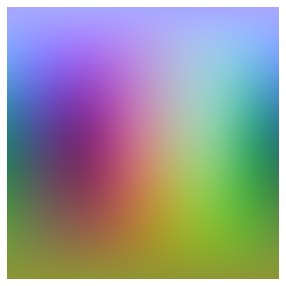

In [204]:
x = torch.arange(0,PI,PI/resolution)
y = torch.arange(0,2*PI,2*PI/resolution)
x_grid,y_grid = torch.meshgrid(x,y, indexing='ij')

Y = torch.zeros((resolution,resolution,3))
for l in range(l_max+1):
    y_lm = get_spherical_harmonics(l,x_grid,y_grid)
    Y += (y_lm@coefs[l][l_max-l:l_max+l+1])


plt.figure(figsize=(5,5))
plt.imshow(Y.clip(0,1))
plt.axis("off")
Y[0,0]

In [17]:

Y = torch.zeros((target_coords.shape[0],3))
for l in range(l_max+1):
    y_lm = get_spherical_harmonics(l,target_coords[:,0],target_coords[:,1])
    Y += (y_lm@coefs[l][l_max-l:l_max+l+1])

plt.plot((Y-target).norm(2,dim=-1))
(Y-target).norm(2,dim=-1).mean()

NameError: name 'target_coords' is not defined

In [18]:
data = [(*list(pos.numpy()),*list((color*255).byte().numpy())) for (pos,color) in zip(cameras,avg_colors.cpu())]
vertices = np.array(data,dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4'),('red', 'u1'),('green', 'u1'),('blue', 'u1')])

ply_file = PlyData(
        [
            PlyElement.describe(
                vertices, 'vertex',
            ),
            plydata["face"]
        ],
         text=True
    )

ply_file.write("vis.ply")

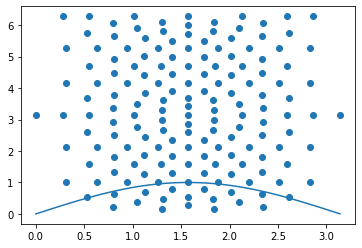

In [19]:
plt.scatter(cameras_spherical[:,0],cameras_spherical[:,1])
x = torch.arange(0,PI,0.01)
plt.plot(x,x.sin())

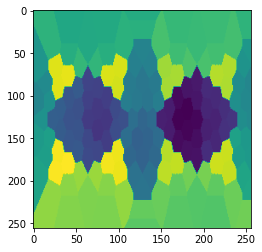

In [129]:
coords_sperical = cameras_spherical.clone()

n = 256
x = torch.arange(0,PI,PI/n)
y = torch.arange(0,2*PI,2*PI/n)
spherical_grid = torch.dstack(torch.meshgrid(x,y, indexing='ij')).flatten(0,1)

distances = torch.cdist(coords_sperical,spherical_grid,p=2)

nearest = distances.argmin(dim=0).reshape((n,n))

plt.imshow(nearest)

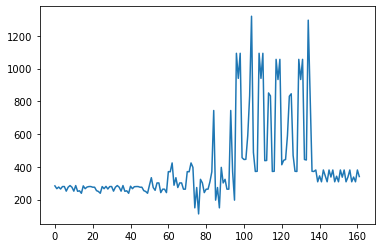

In [131]:
_,counts = nearest.unique(return_counts=True)

plt.plot(counts)

In [ ]:
avg_colors

In [ ]:
(torch.ones((1,10,10))@torch.ones((10,10,1))).sum((0,1))

In [ ]:
n=16
theta = torch.arange(0,PI,PI/n)
phi = torch.arange(0,2*PI,2*PI/n)


theta_grid,phi_grid = torch.meshgrid(theta,phi, indexing='ij')
theta_grid = theta_grid.flatten()
phi_grid = phi_grid.flatten()

x = theta_grid.sin()*phi_grid.cos()
y = theta_grid.sin()*phi_grid.sin()
z = theta_grid.cos()

vertices = np.array([tuple((x,y,z)) for x,y,z in zip(x,y,z)],dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4')])

ply_file = PlyData(
        [
            PlyElement.describe(
                vertices, 'vertex',
            )
        ],
         text=True
    )

ply_file.write("vis.ply")

In [ ]:
n = 100

theta = torch.arange(0,PI,PI/n)
phi = torch.arange(0,2*PI,2*PI/n)


# theta_grid,phi_grid = torch.meshgrid(theta,phi, indexing='ij')
# theta_grid = theta_grid.flatten()
# phi_grid = phi_grid.flatten()


delta = 2* PI**2 / (n*n)
theta_sin = theta_grid.sin().unsqueeze(-1)

(theta_sin*delta).sum()*PI